# <span style='color:Blue'> Assignment 4: Eddy Mean Flow Interaction from Satellite Data
Shanice Bailey (stb2145)

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.113:42147")
client

<Client: 'tcp://10.32.16.113:42147' processes=20 threads=40, memory=230.00 GB>

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import hvplot.xarray
plt.rcParams['figure.figsize'] = (15,10)
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [3]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["sea_surface_height"].to_dask()
ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 8901)
Coordinates:
    crs        int32 ...
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(5, 720, 2), meta=np.ndarray>
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
    lon_bnds   (longitude, nv) float32 dask.array<chunksize=(1440, 2), meta=np.ndarray>
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2017-05-15
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    creator_name:                    CMEMS - Sea Level Thematic Assembly Center
    creator_url:                     http://marine.copernicus.eu
    date_created:                    2014-02-26T16:09:13Z
    date_issued:                     2014-01-06T00:00:00Z
    date_modified:                   2015-11-10T19:42:51Z
    geospatial_lat_max:              89.875
    geospatial_lat_min:              -89.875
    geospatial_lat_resolution:       0.25
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              359.875
    geospatial_lon_min:              0.125
    geospatial_lon_resolution:       0.25
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2014-02-26T16:09:13Z: created by DUACS D...
    institution:                     CLS, CNES
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://marine.copernicus.eu/web/27-servi...
    platform:                        ERS-1, Topex/Poseidon
    processing_level:                L4
    product_version:                 5.0
    project:                         COPERNICUS MARINE ENVIRONMENT MONITORING...
    references:                      http://marine.copernicus.eu
    source:                          Altimetry measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

## <span style='color:Purple'> 1. For the geostrophic velocity anomaly fields (u' and v') calculate M, N, and K by averaging over the whole timeseries

$$
u' = - \frac{\partial \Psi}{\partial y} = -il\Psi = -il\hat{\Psi}e^{i(kx + ly - \omega t)}
$$

$$
v' = - \frac{\partial \Psi}{\partial x} = -ik\Psi = -ik\hat{\Psi}e^{i(kx + ly - \omega t)}
$$

$$M = \frac{1}{2}(\overline{v'^2} - \overline{u'^2}) = \frac{1}{2}(\frac{1}{2}k^2 |\hat{\Psi}|^2) = \frac{1}{2}(k^2 - l^2)\frac{1}{2}|\hat{\Psi}|^2$$

$$N = \overline{u'v'} = \frac{1}{2}Re[(-il\hat{\Psi})^*]Re(ik\hat{\Psi}) = -kl(\frac{1}{2}|\hat{\Psi}|^2)$$

$$K = \frac{1}{2}(\overline{v'^2} + \overline{u'^2}) = \frac{1}{2}(k^2 + l^2)\frac{1}{2}|\hat{\Psi}|^2$$

In [4]:
u_prime_bar = (ds.ugosa**2).mean(dim='time')
v_prime_bar = (ds.vgosa**2).mean(dim='time')
bar_u_prime_v_prime = (ds.ugosa * ds.vgosa).mean(dim='time')

In [5]:
M = 0.5 * (v_prime_bar - u_prime_bar)
N = u_prime_bar * v_prime_bar
K = 0.5 * (v_prime_bar + u_prime_bar)

In [6]:
M.load()

<xarray.DataArray (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

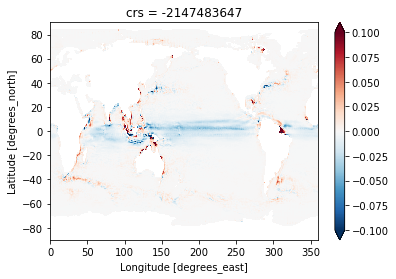

In [7]:
M.plot(vmax=0.1)

## <span style='color:Purple'> 2. Make vector plots of the a) Zonal Eddy Momentum Flux and b) Meridional Eddy Momentum Flux. (The two columns of tau)

$$
A = \tau_{\textbf{x,y}} = \begin{array}{cc}
   \overline{u'^2} & \overline{u'v'} \\
   \overline{u'v'} & \overline{v'^2} \\
  \end{array}
$$
All of A is bounded by K

In [8]:
taux = -M, N
tauy = N, M

### <span style='color:Purple'> a) Zonal Eddy Momentum Flux

In [9]:
taux[0].load()

<xarray.DataArray (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

In [10]:
taux[1].load()

<xarray.DataArray (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

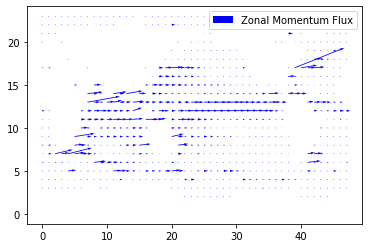

In [11]:
nd = 30
plt.quiver(taux[0][::nd, ::nd], taux[1][::nd, ::nd], color='blue', label='Zonal Momentum Flux', angles='xy', scale_units='xy', scale=0.05)
plt.legend();

### <span style='color:Purple'> b) Meridional Eddy Momentum Flux

In [12]:
tauy[0].load()

<xarray.DataArray (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

In [13]:
tauy[1].load()

<xarray.DataArray (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

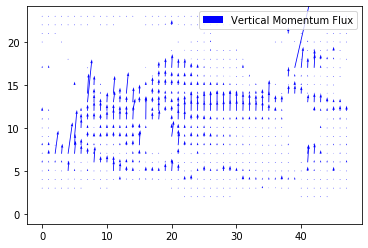

In [14]:
nd = 30
plt.quiver(tauy[0][::nd, ::nd], tauy[1][::nd, ::nd], color='blue', label='Vertical Momentum Flux', angles='xy', scale_units='xy', scale=0.05)
plt.legend();

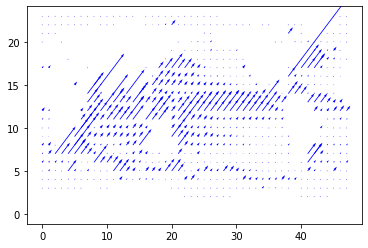

In [15]:
plt.quiver((taux[0][::nd, ::nd]+tauy[0][::nd, ::nd]),
           (taux[1][::nd, ::nd]+tauy[1][::nd, ::nd]), color='blue', label='Horizontal Momentum Flux', angles='xy', scale_units='xy', scale=0.05)

## <span style='color:Purple'> 3. Calculate and plot K, gamma_m, and phi_m globally

* $$\gamma_m = \frac{\sqrt{M^2 + N^2}}{K}$$
* $$\Phi_m = \frac{1}{2}cos^{-1}(\frac{-M}{\sqrt{M^2 + N^2}}) \longrightarrow cos(2\Phi_m) = \frac{-M}{\sqrt{M^2 + N^2}}$$

In [16]:
gamma_m = np.sqrt(M**2 + N**2) / K
phi_m = 0.5 * np.arccos(-M / np.sqrt(M**2 + N**2))

In [18]:
gamma_m.load()

<xarray.DataArray (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

In [17]:
K.load()

<xarray.DataArray (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

In [19]:
phi_m.load()

<xarray.DataArray (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    crs        int32 -2147483647
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875

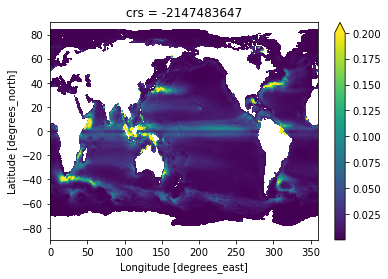

In [34]:
K.plot(vmax=0.2)

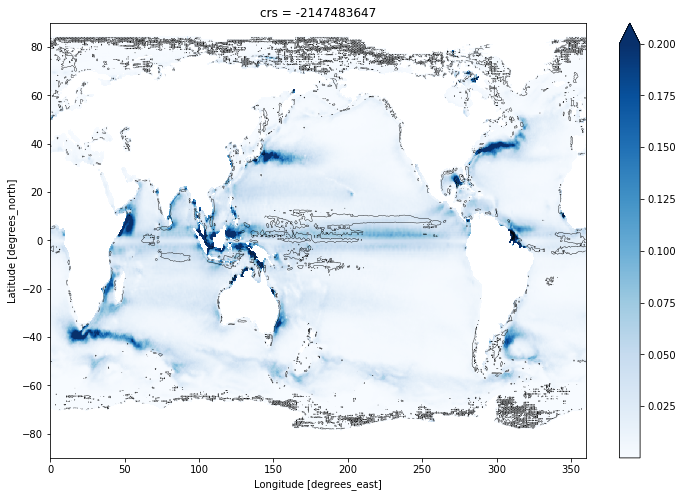

In [62]:
fig, ax = plt.subplots(figsize=(12,8))
plt.contour(gamma_m.longitude, gamma_m.latitude, gamma_m, vmax=1, levels=10, linewidths=0.4, colors='k')
K.plot(vmax=0.2, cmap='Blues', ax=ax)

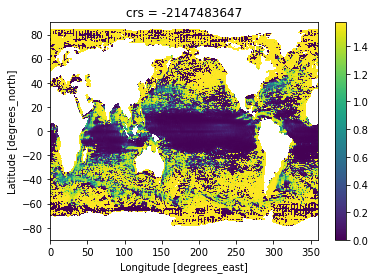

In [66]:
phi_m.plot()

## <span style='color:Purple'> 4. Make some zoomed in plots of K, gamma_m, and phi_m in the a) gulf stream, b) kuroshio, c) equator, d) ACC. Try to ascertain whether the eddy forcing is accelerating or decelerating these jets

## <span style='color:Purple'> a) gulf stream
    
<span style='color:orange'> **Based on the anisotropic contours, $\gamma_m$, over the KE in the Gulfstream I'd say the eddies are accelerating the momentum fluxes.**

In [86]:
lower_lat_g = 25.125
upper_lat_g = 60.125
left_lon_g = 280.125
right_lon_g = 330.125

lat_range_g = dict(latitude=slice(lower_lat_g, upper_lat_g))
lon_range_g = dict(longitude=slice(left_lon_g, right_lon_g))

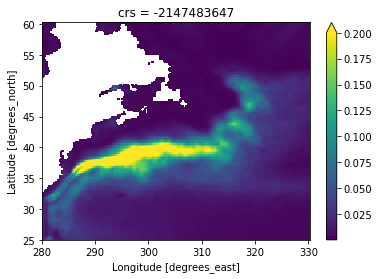

In [87]:
K.sel(**lat_range_g, **lon_range_g).plot(vmax=0.2)

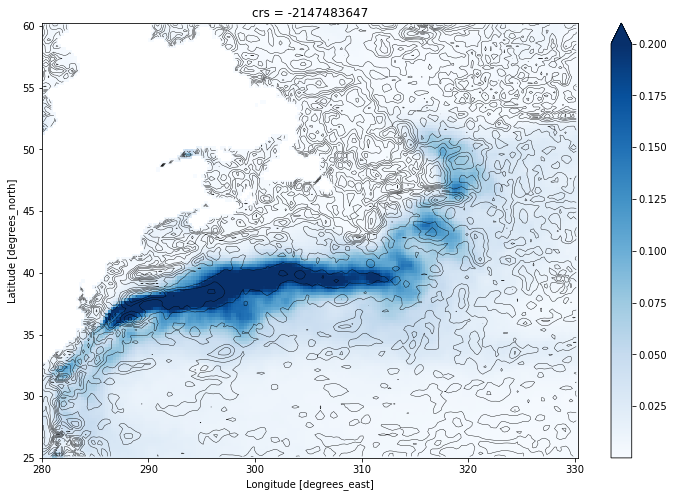

In [88]:
fig, ax = plt.subplots(figsize=(12,8))
plt.contour(gamma_m.longitude.sel(**lon_range_g), gamma_m.latitude.sel(**lat_range_g), 
            gamma_m.sel(**lon_range_g, **lat_range_g), vmax=1, levels=10, linewidths=0.4, colors='k')
K.sel(**lat_range_g, **lon_range_g).plot(vmax=0.2, cmap='Blues', ax=ax)

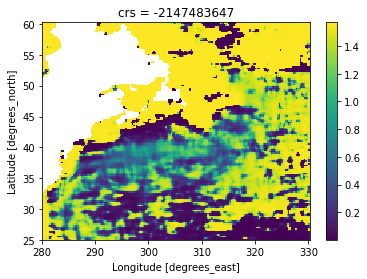

In [89]:
phi_m.sel(**lat_range_g, **lon_range_g).plot()

## <span style='color:Purple'> b) kuroshio

<span style='color:orange'> **Based on the anisotropic contours, $\gamma_m$, over the KE in the Kuroshio, it looks like the eddies closest to the coasts have the bigest impact on the momentum fluxes instead of the region where there is the most kinetic energy.**

In [96]:
lower_lat_k = 10.125
upper_lat_k = 50.125
left_lon_k = 130.125
right_lon_k = 200.125

lat_range_k = dict(latitude=slice(lower_lat_k, upper_lat_k))
lon_range_k = dict(longitude=slice(left_lon_k, right_lon_k))

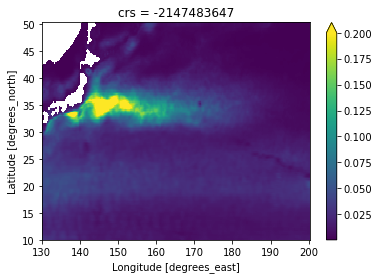

In [97]:
K.sel(**lat_range_k, **lon_range_k).plot(vmax=0.1)

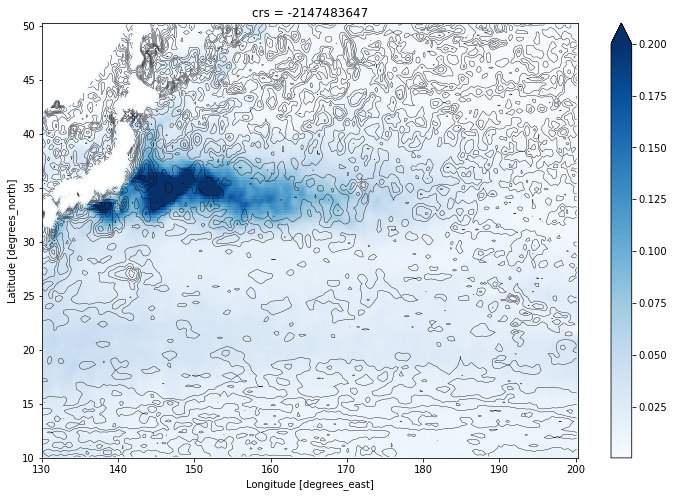

In [101]:
fig, ax = plt.subplots(figsize=(12,8))
plt.contour(gamma_m.longitude.sel(**lon_range_k), gamma_m.latitude.sel(**lat_range_k), 
            gamma_m.sel(**lon_range_k, **lat_range_k), vmax=1, levels=10, linewidths=0.4, colors='k')
K.sel(**lat_range_k, **lon_range_k).plot(vmax=0.2, cmap='Blues', ax=ax)

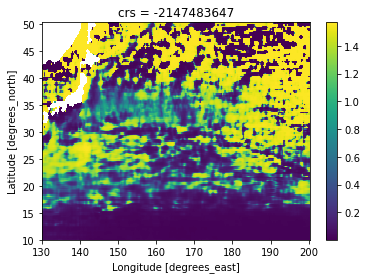

In [102]:
phi_m.sel(**lat_range_k, **lon_range_k).plot()

## <span style='color:Purple'> c) equator
<span style='color:orange'> **Based on the anisotropic contours, $\gamma_m$, over the KE around the equator, the regions where eddies have the most impact are around western Atlantic. So... around the rest of the equatorial belt, the eddy forcings are decelerating the jets.**

In [111]:
lower_lat_e = -10.125
upper_lat_e = 10.125

lat_range_e = dict(latitude=slice(lower_lat_e, upper_lat_e))

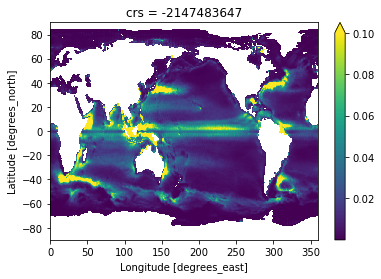

In [112]:
K.plot(vmax=0.1)

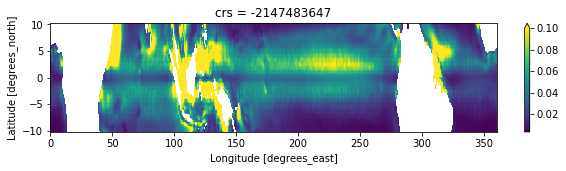

In [114]:
K.sel(**lat_range_e).plot(figsize=(10,2), vmax=0.1)

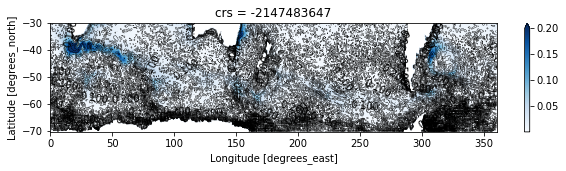

In [128]:
fig, ax = plt.subplots(figsize=(10,2))
plt.contour(gamma_m.longitude, gamma_m.latitude.sel(**lat_range_e), 
            gamma_m.sel(**lat_range_e), vmax=1, levels=10, linewidths=0.4, colors='k')
K.sel(**lat_range_e).plot(vmax=0.2, cmap='Blues', ax=ax)

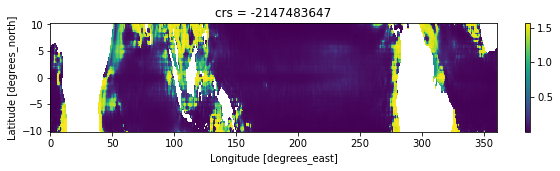

In [119]:
phi_m.sel(**lat_range_e).plot(figsize=(10,2))

## <span style='color:Purple'> d) ACC

<span style='color:orange'> **Based on the large amount of anisotropic contours, $\gamma_m$, in the ACC, I'd say the eddy forcings are accelerating the jets, especially near the coasts of Antarctica.**

In [123]:
lower_lat_acc = -70.125
upper_lat_acc = -30.125

lat_range_acc = dict(latitude=slice(lower_lat_acc, upper_lat_acc))

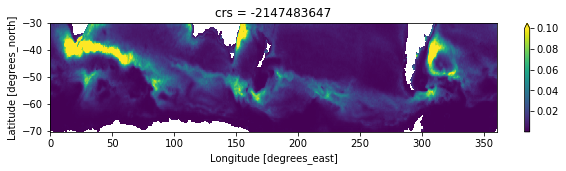

In [124]:
K.sel(**lat_range_acc).plot(figsize=(10,2), vmax=0.1)

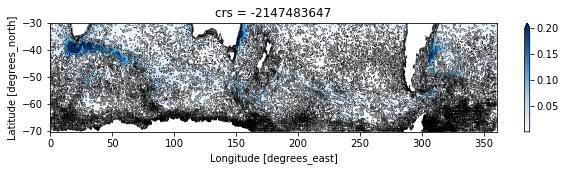

In [125]:
fig, ax = plt.subplots(figsize=(10,2))
plt.contour(gamma_m.longitude, gamma_m.latitude.sel(**lat_range_acc), 
            gamma_m.sel(**lat_range_acc), vmax=1, levels=10, linewidths=0.4, colors='k')
K.sel(**lat_range_acc).plot(vmax=0.2, cmap='Blues', ax=ax)

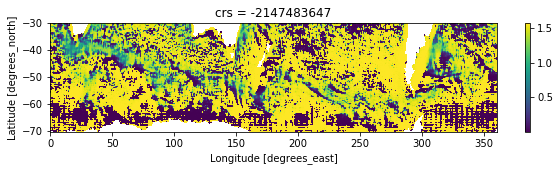

In [126]:
phi_m.sel(**lat_range_acc).plot(figsize=(10,2))